In [1]:
import torch, torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
import json

In [2]:
import numpy as np
from typing import *
from torch.nn.utils.rnn import pad_sequence
import random

In [3]:
config_path = "configs/config_v1.json"

In [4]:
class AttrDict(dict):
    """
    From https://github.com/jik876/hifi-gan
    """
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [5]:
with open(f"{config_path}") as file:
    config = AttrDict(json.load(file))

In [6]:
with open("configs/h.json") as file:
    h = AttrDict(json.load(file))

In [7]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root: str):
        super().__init__(root=root)
    
    def __getitem__(self, index: int):
        waveform, sr, _, transcript = super().__getitem__(index)
        waveform_length = torch.tensor([waveform.shape[-1]]).int()
        
        return transcript, waveform, waveform_length

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
dataset = LJSpeechDataset(config.path_to_data)

In [13]:
train_size = int(config.train_ratio * len(dataset))
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, len(dataset) - train_size],
    generator=torch.Generator().manual_seed(config.seed)
)

In [14]:
from dataclasses import dataclass

@dataclass
class Batch:
    transcript: List[str]
    waveform: torch.Tensor
    waveform_length: torch.Tensor
    melspec: Optional[torch.Tensor] = None
    melspec_loss: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> "Batch":
        batch = Batch(
            self.transcript,
            self.waveform.to(device),
            self.waveform_length.to(device),
            self.melspec.to(device),
            self.melspec_loss.to(device)
        )
        return batch

In [15]:
class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        transcript, waveform, waveform_length = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)

        waveform_length = torch.cat(waveform_length)

        batch = Batch(
            transcript, waveform, waveform_length
        )

        return batch


In [16]:
train_dataloader = DataLoader(
    train_dataset, 
    collate_fn=LJSpeechCollator(),
    batch_size=config.batch_size, 
    #num_workers=config.num_workers
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=LJSpeechCollator(),
    batch_size=config.batch_size, 
    #num_workers=config.num_workers
)

In [17]:
import librosa
import wandb
import torch.nn as nn

In [18]:
from librosa.filters import mel as librosa_mel_fn

In [19]:
def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)
    

def spectral_normalize_torch(magnitudes):
    out = dynamic_range_compression_torch(magnitudes)
    return out


class MelSpectrogram(nn.Module):

    def __init__(self, config, for_loss=False):
        super(MelSpectrogram, self).__init__()

        self.f_max = config.f_max if for_loss is False else config.f_max_loss
        self.pad_size = (config.n_fft - config.hop_length) // 2
        self.config = config

    def forward(self, audio: torch.Tensor) -> torch.Tensor:

        spec_1 = librosa_mel_fn(
            self.config.sr, self.config.n_fft, self.config.n_mels, 
            self.config.f_min, self.f_max
        )

        audio = torch.nn.functional.pad(
            audio.unsqueeze(1), (self.pad_size, self.pad_size), mode='reflect'
        ).squeeze(1)

        spec_2 = torch.stft(
            audio, 
            self.config.n_fft, 
            hop_length=self.config.hop_length, 
            win_length=self.config.win_length, 
            window=torch.hann_window(self.config.win_length),
            center=self.config.center, 
            pad_mode='reflect', 
            normalized=False, 
            onesided=True
        )

        spec_2 = torch.sqrt(spec_2.pow(2).sum(-1) + (1e-9))
        
        melspec = torch.matmul(torch.from_numpy(spec_1).float(), spec_2)
        melspec = spectral_normalize_torch(melspec)

        return melspec

In [21]:
melspectrogramer = MelSpectrogram(config, for_loss=False).to(device)
melspectrogramer_loss = MelSpectrogram(config, for_loss=True).to(device)

In [22]:
def prepare_batch(
    batch: Batch, 
    melspectrogramer: MelSpectrogram, 
    melspectrogramer_loss: MelSpectrogram,
    device: torch.device,
    for_training: bool, 
    segment_size: int = 8192
):  
    if for_training: 
        waveform_segment = []

        for idx in range(batch.waveform.shape[0]):
            waveform_length = batch.waveform_length[idx]
            waveform = batch.waveform[idx][:waveform_length]

            if waveform_length >= segment_size:
                difference = waveform_length - segment_size
                waveform_start = random.randint(0, difference - 1)
                waveform_segment.append(
                    waveform[waveform_start:waveform_start + segment_size]
                )
            else:
                waveform_segment.append(
                    F.pad(waveform, (0, segment_size - waveform_length))
                )
        
        batch.waveform = torch.vstack(waveform_segment)
    
    batch.melspec = melspectrogramer(batch.waveform.to(device))
    batch.melspec_loss = melspectrogramer_loss(batch.waveform.to(device))
    
    return batch.to(device)

In [23]:
for batch in train_dataloader:
    break
    batch = prepare_batch(batch, melspectrogramer, aligner, config, device)

In [24]:
batch = prepare_batch(batch, melspectrogramer, melspectrogramer_loss, device, for_training=True)

/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:572: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:659.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [25]:
import matplotlib.pyplot as plt

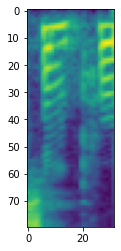

In [26]:
plt.imshow(batch.melspec[0])

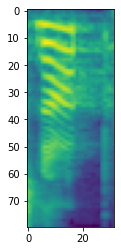

In [27]:
plt.imshow(batch.melspec_loss[1])

In [28]:
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

In [29]:
def get_padding(kernel_size, dilation=1):
    """
    From https://github.com/jik876/hifi-gan
    """
    return int((kernel_size * dilation - dilation) / 2)


def init_weights(m, mean=0.0, std=0.01):
    """
    From https://github.com/jik876/hifi-gan
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)

In [30]:
LRELU_SLOPE = 1e-1

In [31]:
class ResSubBlock(nn.Module):

    def __init__(
        self, 
        channels: int,  
        kernel_size: int, 
        dilation: int
    ):
        super(ResSubBlock, self).__init__()

        self.res_sub_block = nn.Sequential(
            nn.LeakyReLU(
                negative_slope=LRELU_SLOPE, 
                inplace=True
            ),
            weight_norm(
                nn.Conv1d(
                    in_channels=channels,
                    out_channels=channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    padding=get_padding(kernel_size, dilation)
                )
            )
        )

        self.res_sub_block.apply(init_weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        
        Returns: 
            out: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        """
        out = x + self.res_sub_block(x) 
        
        return out
        

class ResBlock(nn.Module):

    def __init__(
        self, 
        channels: int,
        kernel_size: int, 
        dilation_rates: int
    ):
        super(ResBlock, self).__init__()

        self.res_block = nn.Sequential(
            *[
                ResSubBlock(
                    channels, 
                    kernel_size, 
                    dilation_rates[m][ell]
                )
                for m in range(len(dilation_rates)) for ell in range(len(dilation_rates[m]))
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        
        Returns: 
            out: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        """
        out = self.res_block(x)

        return out


class MultiReceptiveFieldFusion(nn.Module):

    def __init__(
        self, 
        channels: int, 
        resblock_kernel_sizes: int, 
        dilation_rates: int
    ):
        super(MultiReceptiveFieldFusion, self).__init__()
        
        self.mrf = nn.Sequential(
            *[
                ResBlock(
                    channels, 
                    resblock_kernel_sizes[n], 
                    dilation_rates[n]
                ) 
                for n in range(len(resblock_kernel_sizes))
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        
        Returns: 
            out: torch.Tensor with shape of (batch_size, n_mels, seq_len)
        """
        for i, res_block in enumerate(self.mrf):
            if i == 0:
                out = res_block(x)
            else:
                out += res_block(x)
            
        return out / len(self.mrf)


class UpsamplerBlock(nn.Module):

    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int, 
        stride: int, 
        resblock_kernel_sizes: List[int], 
        dilation_rates: List[int]
    ):
        super(UpsamplerBlock, self).__init__()

        self.upsampler_block = nn.Sequential(
            nn.LeakyReLU(
                negative_slope=LRELU_SLOPE, 
                inplace=True
            ),
            weight_norm(
                nn.ConvTranspose1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=(kernel_size - stride) // 2,
                )
            ),
            MultiReceptiveFieldFusion(
                out_channels, 
                resblock_kernel_sizes, 
                dilation_rates
            )
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: torch.Tensor with shape of (batch_size, n_mels, seq_len)

        Returns:
            out: torch.Tensor with shape of (batch_size, n_mels // 2, seq_len * 8)
        """
        out = self.upsampler_block(x)

        return out


class HiFiGenerator(nn.Module):

    def __init__(self, config):
        super(HiFiGenerator, self).__init__()
        
        dilation_rates = [config.dilation_rates] * 3

        self.conv_in = weight_norm(
            nn.Conv1d(
                in_channels=config.n_mels,
                out_channels=config.initial_channels,
                kernel_size=7,
                stride=1,
                padding=3
            )
        )

        self.upsampler = nn.Sequential(
            *[
                UpsamplerBlock(
                    in_channels=config.initial_channels // (2 ** i),
                    out_channels=config.initial_channels // (2 ** (i + 1)),
                    kernel_size=config.upsample_kernel_sizes[i],
                    stride=config.upsample_kernel_sizes[i] // 2, 
                    resblock_kernel_sizes=config.resblock_kernel_sizes,
                    dilation_rates=dilation_rates
                )
                for i in range(len(config.upsample_kernel_sizes))
            ]
        )

        self.conv_out = nn.Sequential(
            nn.LeakyReLU(
                negative_slope=LRELU_SLOPE, 
                inplace=True
            ),
            weight_norm(
                nn.ConvTranspose1d(
                    in_channels=config.initial_channels // (2 ** len(config.upsample_kernel_sizes)),
                    out_channels=1,
                    kernel_size=7,
                    padding=3
                )
            ),
            nn.Tanh()
        )

        self.conv_out.apply(init_weights)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: melspec — torch.Tensor with shape of (batch_size, n_mels, seq_len)
        
        Returns: 
            out: torch.Tensor with shape of 
        """
        out = self.conv_out(self.upsampler(self.conv_in(x)))

        return out.squeeze()

In [33]:
class PeriodSubDiscriminator(nn.Module):

    """
    Operates on disjoint samples of raw waveforms.
    """
    
    def __init__(
        self, 
        period: int, 
        powers: List[int] = [0, 5, 7, 9, 10]
    ):
        super(PeriodSubDiscriminator, self).__init__()
        
        self.period = period

        self.convs = nn.Sequential(
            *[  
                nn.Sequential(
                    weight_norm(
                        nn.Conv2d(
                            in_channels=2 ** powers[ell], 
                            out_channels=2 ** powers[ell + 1], 
                            kernel_size=(5, 1), 
                            stride=(3, 1), 
                            padding=(get_padding(5, 1), 0)
                        )
                    ),
                    nn.LeakyReLU(
                        negative_slope=LRELU_SLOPE, 
                        inplace=True
                    )
                ) 
                for ell in range(4)
            ],
            nn.Sequential(
                weight_norm(
                    nn.Conv2d(
                        in_channels=1024, 
                        out_channels=1024, 
                        kernel_size=(5, 1), 
                        stride=1, 
                        padding=(2, 0)
                    )
                ),
                nn.LeakyReLU(
                    negative_slope=LRELU_SLOPE, 
                    inplace=True
                )
            ),
            nn.Sequential(
                weight_norm(
                    nn.Conv2d(
                        in_channels=1024, 
                        out_channels=1, 
                        kernel_size=(3, 1), 
                        stride=1, 
                        padding=(1, 0)
                    )
                )
            )
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        Params:
            x: wav — torch.Tensor with shape of (batch_size, seq_len)
        
        Retruns: 
            out: torch.Tensor with shape of (batch_size, seq_len)
            feature_map: List[tensor.Torch] 
        """
        batch_size, seq_len = x.shape
        if seq_len % self.period != 0:
            pad_len = self.period - seq_len % self.period
            x = F.pad(x, (0, pad_len), "reflect")
            seq_len += pad_len

        # Reshape from 1D to 2D
        out = x.view(batch_size, 1, seq_len // self.period, self.period)

        feature_map = []
        for conv_ell in self.convs:
            out = conv_ell(out)
            feature_map.append(out)
        
        out = torch.flatten(out, start_dim=1, end_dim=-1)
        
        return out, feature_map


class MultiPeriodDiscriminator(nn.Module):

    def __init__(self, config):
        super(MultiPeriodDiscriminator, self).__init__()

        self.sub_discriminators = nn.Sequential(
            *[
                PeriodSubDiscriminator(period)
                for period in config.mpd_periods
            ]
        )
        
    def forward(
        self, 
        wav_real: torch.Tensor, 
        wav_fake: torch.Tensor
    ) -> Tuple[List[torch.Tensor], List[List[torch.Tensor]]]:
        """
        Params:
            wav_real: torch.Tensor with shape of (batch_size, seq_len)
            wav_fake: generated wav — torch.Tensor with shape of (batch_size, seq_len)
        """
        mpd_outs_true, mpd_outs_gen = [], []
        feature_maps_true, feature_maps_gen = [], []

        for sub_discriminator in self.sub_discriminators:
            out_real, feature_map_true = sub_discriminator(wav_real)
            mpd_outs_true.append(out_real)
            feature_maps_true.append(feature_map_true)

            out_gen, feature_map_gen = sub_discriminator(wav_fake)
            mpd_outs_gen.append(out_gen)
            feature_maps_gen.append(feature_map_gen)
        
        return mpd_outs_true, mpd_outs_gen, feature_maps_true, feature_maps_gen

In [34]:
class ScaleSubDiscriminator(nn.Module):

    """
    Operates on smoothed waveforms.
    """
    
    def __init__(
        self,
        powers: List[int] = [0, 7, 7, 8, 9, 10, 10, 10],
        kernel_sizes: List[int] = [15, 41, 41, 41, 41, 41, 5], 
        strides: List[int] = [1, 2, 2, 4, 4, 1, 1],
        groups: List[int] = [1, 4, 16, 16, 16, 16, 1],
        padding: List[int] = [7, 20, 20, 20, 20, 20, 2],
        use_spectral_norm=False
    ):
        super(ScaleSubDiscriminator, self).__init__()

        norm = weight_norm if use_spectral_norm == False else spectral_norm

        self.convs = nn.Sequential(
            *[  
                nn.Sequential(
                    norm(
                        nn.Conv1d(
                            in_channels=2 ** powers[ell], 
                            out_channels=2 ** powers[ell + 1], 
                            kernel_size=kernel_sizes[ell], 
                            stride=strides[ell], 
                            groups=groups[ell],
                            padding=padding[ell]
                        )
                    ),
                    nn.LeakyReLU(
                        negative_slope=LRELU_SLOPE, 
                        inplace=True
                    )
                ) 
                for ell in range(7)
            ], 
            nn.Sequential(
                norm(
                    nn.Conv1d(
                        in_channels=1024, 
                        out_channels=1, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1
                    )
                )
            )
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        feature_map = []
        
        for conv_ell in self.convs:
            x = conv_ell(x)
            feature_map.append(x)
    
        out = torch.flatten(x, start_dim=1, end_dim=-1)
    
        return out, feature_map


class MultiScaleDiscriminator(nn.Module):

    def __init__(self, config):
        super(MultiScaleDiscriminator, self).__init__()

        self.sub_discriminators = nn.Sequential(
            *[
                ScaleSubDiscriminator(use_spectral_norm=config.msd_use_spectral_norm[i])
                for i in range(len(config.msd_use_spectral_norm))
            ]
        )
        
        self.mean_pool = nn.AvgPool1d(
            kernel_size=4, 
            stride=2, 
            padding=2
        )
    
    def forward(
        self, 
        wav_real: torch.Tensor, 
        wav_fake: torch.Tensor
    ) -> Tuple[List[torch.Tensor], List[List[torch.Tensor]]]:
        """
        Params:
            wav_real: true wav — torch.Tensor with shape of (batch_size, seq_len)
            wav_fake: generated wav — torch.Tensor with shape of (batch_size, seq_len)
        """
    
        wav_real, wav_fake = wav_real.unsqueeze(1), wav_fake.unsqueeze(1)

        msd_outs_true, msd_outs_gen = [], []
        feature_maps_true, feature_maps_gen = [], []

        for i, sub_discriminator in enumerate(self.sub_discriminators):
            
            if i != 0:
                wav_real = self.mean_pool(wav_real)
                wav_fake = self.mean_pool(wav_fake)

            out_real, feature_map_true = sub_discriminator(wav_real)
            msd_outs_true.append(out_real)
            feature_maps_true.append(feature_map_true)

            out_gen, feature_map_gen = sub_discriminator(wav_fake)
            msd_outs_gen.append(out_gen)
            feature_maps_gen.append(feature_map_gen)

        return msd_outs_true, msd_outs_gen, feature_maps_true, feature_maps_gen

In [55]:
class HiFiDiscriminator(nn.Module):
    
    def __init__(self, config): 
        super(HiFiDiscriminator, self).__init__()

        self.multi_period_discriminator = MultiPeriodDiscriminator(config)
        self.multi_scale_discriminator = MultiScaleDiscriminator(config)
    
    def forward(
        self,
        wav_real: torch.Tensor, 
        wav_fake: torch.Tensor
    ) -> Tuple[Tuple[List[torch.Tensor], List[List[torch.Tensor]]]]:

        out_mpd = self.multi_period_discriminator(wav_real, wav_fake)
        out_msd = self.multi_scale_discriminator(wav_real, wav_fake)

        NAMES = [
            "outs_real",
            "outs_fake",
            "feature_maps_real",
            "feature_maps_fake"
        ]

        out_discr = {
            key: v_mpd + v_msd for (key, v_mpd, v_msd) in zip(NAMES, out_mpd, out_msd)
        }

        return out_discr

In [56]:
generator = HiFiGenerator(config).to(device)
discriminator = HiFiDiscriminator(config).to(device) 

In [59]:
optimizer_generator = torch.optim.AdamW(
    generator.parameters(), 
    betas=(0.8, 0.99), 
    weight_decay=0.01, 
    lr=2e-4
) # change to config and check with paper
optimizer_discriminator = torch.optim.AdamW(
    discriminator.parameters(), 
    betas=(0.8, 0.99), 
    weight_decay=0.01, 
    lr=2e-4
)

scheduler_generator = torch.optim.lr_scheduler.ExponentialLR(
    optimizer_generator, 
    gamma=0.999
)  # change to config and check with paper
scheduler_discriminator = torch.optim.lr_scheduler.ExponentialLR(
    optimizer_discriminator, 
    gamma=0.999
)

In [134]:
class AdversarialLoss(nn.Module):

    def forward(
        self, 
        outs_fake: List[torch.Tensor]
    ) -> torch.Tensor:

        loss_adv = 0

        for out_fake in outs_fake:
            loss_adv += torch.mean(
                (out_fake - 1) ** 2
            )
        
        return loss_adv

In [95]:
class MelSpectrogramLoss(nn.Module):

    def forward(
        self,
        melspec_real: torch.Tensor,
        melspec_fake: torch.Tensor
    ) -> torch.Tensor:

        loss_mel = torch.mean(
            torch.abs(melspec_real - melspec_fake)
        )

        return loss_mel
        

In [132]:
class FeatureMatchingLoss(nn.Module):

    def forward(
        self,
        feature_maps_real: List[torch.Tensor],
        feature_maps_fake: List[torch.Tensor]
    ) -> torch.Tensor:

        loss_fm = 0
        for feature_map_real, feature_map_fake \
            in zip(feature_maps_real, feature_maps_fake):

            loss_fm = 0
            for sub_feature_map_real, sub_feature_map_fake \
                in zip(feature_map_real, feature_map_fake):
                loss_fm += torch.mean(
                    torch.abs(sub_feature_map_real - sub_feature_map_fake) 
                )
                loss_fm /= sub_feature_map_real.shape[1]

        return loss_fm

In [91]:
class DiscriminatorLoss(nn.Module):

    def forward(
        self, 
        outs_real: List[torch.Tensor], 
        outs_fake: List[torch.Tensor]
    ) -> torch.Tensor:
    
        discriminator_loss = 0

        for out_real, out_fake in zip(outs_real, outs_fake): 
            discriminator_loss += torch.mean(
                (out_real - 1) ** 2 + out_fake ** 2
            )
        
        return discriminator_loss


In [146]:
adversarial_loss = AdversarialLoss()
feature_loss = FeatureMatchingLoss()
melspec_loss = MelSpectrogramLoss()

In [144]:
wav_real, melspec_real = batch.waveform, batch.melspec

wav_fake = generator(melspec_real)
melspec_fake = melspectrogramer_loss(wav_fake)

out_discr = discriminator(wav_real, wav_fake)

In [147]:
loss_adv = adversarial_loss(out_discr["outs_fake"])
loss_fm = feature_loss(out_discr["feature_maps_real"], out_discr["feature_maps_fake"])
loss_mel = melspec_loss(melspec_real, melspec_fake)

In [148]:
loss_generator = loss_adv + 2 * loss_fm + 45 * loss_mel
loss_generator.backward()

In [151]:
torch.autograd.set_detect_anomaly(True)

In [152]:
loss_generator.backward()

/opt/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: Error detected in MulBackward0. No forward pass information available. Enable detect anomaly during forward pass for more information. (Triggered internally at  ../torch/csrc/autograd/python_anomaly_mode.cpp:85.)
  Variable._execution_engine.run_backward(


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
(batch.melspec_loss, melspec_fake)